In [ ]:
from math import sqrt
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df = read_csv('/content/gdrive/MyDrive/Colab Notebooks/procecssed_df.csv', index_col=[0])
df['date'] = pd.to_datetime(df['date'])
states = list(df['location_name'].unique())

In [ ]:
df

,date,location,location_name,hospitalizations,smoothed_hosp,cases,smoothed_cases,spc,sph
0,2020-08-02,54,West Virginia,15,13.571429,120,138.428571,1.667824,0.135794
1,2020-08-03,54,West Virginia,16,12.714286,120,139.857143,1.613695,0.130553
2,2020-08-04,54,West Virginia,17,12.857143,81,134.142857,1.594363,0.130621
3,2020-08-05,54,West Virginia,10,13.285714,103,126.428571,1.578601,0.129031
4,2020-08-06,54,West Virginia,15,12.571429,116,129.000000,1.553070,0.126456
...,...,...,...,...,...,...,...,...,...
22976,2021-11-09,12,Florida,209,197.571429,0,1499.714286,2.640175,0.186948
22977,2021-11-10,12,Florida,197,196.571429,0,1499.714286,2.699973,0.188298
22978,2021-11-11,12,Florida,172,193.000000,0,1499.714286,2.558361,0.188551
22979,2021-11-12,12,Florida,173,188.285714,10302,1471.714286,2.821568,0.189012


### Function for converting LSTM input format

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### LSTM Prediction 

### Local Model 3: Smoothed hospitalization + Smoothed cases + SPC

In [ ]:
n_days = 21
n_features = 3

prediction_dict = {}

state='California'
#for state in states:
print('-----', state, '-----')

state_df = df[df['location_name']=='California']
values = state_df[['smoothed_hosp', 'smoothed_cases', 'spc']].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, n_days, 1)
# drop columns we don't want to predict
# print(reframed.head())

score_dict = {'train_rmse':[],
              'test_rmse': []}

for i in range(0,10):
    # split into train and test sets
    values = reframed.values
    n_train_days = int(len(values) * 0.8)
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]
    # split into input and outputs
    n_obs = n_days * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    # print(train_X.shape, len(train_X), train_y.shape)
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
    # print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

    # Early stop
    # early_stopping = EarlyStopping(
    #     monitor='val_loss',
    #     patience=8,
    #     min_delta=0.001,
    #     mode='max'
    # )

    # design network
    model = Sequential()
    model.add(LSTM(64, activation='tanh',
                   return_sequences=True,
                   input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(64, activation='tanh'))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')


    # fit network
    history = model.fit(train_X, train_y, epochs=200, 
                        batch_size=72, 
                        validation_data=(test_X, test_y), 
                        verbose=2, shuffle=False)
    # plot history
    #     pyplot.plot(history.history['loss'], label='train')
    #     pyplot.plot(history.history['val_loss'], label='test')
    #     pyplot.legend()
    #     pyplot.show()

    model_predict_train = model.predict(train_X)
    train_X = train_X.reshape((train_X.shape[0], n_days*n_features))
    # invert scaling for forecast
    inv_yhat_train = concatenate((model_predict_train, train_X[:, -(n_features-1):]), axis=1)
    inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
    inv_yhat_train = inv_yhat_train[:,0]
    # invert scaling for actual
    train_y = train_y.reshape((len(train_y), 1))
    inv_y_train = concatenate((train_y, train_X[:, -(n_features-1):]), axis=1)
    inv_y_train = scaler.inverse_transform(inv_y_train)
    inv_y_train = inv_y_train[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y_train, inv_yhat_train))
    print('Train RMSE: %.3f' % rmse)
    score_dict['train_rmse'].append(rmse)

    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    score_dict['test_rmse'].append(rmse)

    model_predict = concatenate([inv_yhat_train, inv_yhat])
    prediction_dict[state] = model_predict
    
print(DataFrame(score_dict))

----- California -----
Epoch 1/200
5/5 - 5s - loss: 0.2024 - val_loss: 0.0666 - 5s/epoch - 1s/step
Epoch 2/200
5/5 - 0s - loss: 0.0887 - val_loss: 0.1507 - 97ms/epoch - 19ms/step
Epoch 3/200
5/5 - 0s - loss: 0.0766 - val_loss: 0.0818 - 92ms/epoch - 18ms/step
Epoch 4/200
5/5 - 0s - loss: 0.0413 - val_loss: 0.0354 - 88ms/epoch - 18ms/step
Epoch 5/200
5/5 - 0s - loss: 0.0531 - val_loss: 0.0637 - 89ms/epoch - 18ms/step
Epoch 6/200
5/5 - 0s - loss: 0.0432 - val_loss: 0.0879 - 93ms/epoch - 19ms/step
Epoch 7/200
5/5 - 0s - loss: 0.0344 - val_loss: 0.0419 - 92ms/epoch - 18ms/step
Epoch 8/200
5/5 - 0s - loss: 0.0399 - val_loss: 0.0624 - 96ms/epoch - 19ms/step
Epoch 9/200
5/5 - 0s - loss: 0.0356 - val_loss: 0.0697 - 92ms/epoch - 18ms/step
Epoch 10/200
5/5 - 0s - loss: 0.0294 - val_loss: 0.0283 - 98ms/epoch - 20ms/step
Epoch 11/200
5/5 - 0s - loss: 0.0369 - val_loss: 0.0416 - 90ms/epoch - 18ms/step
Epoch 12/200
5/5 - 0s - loss: 0.0309 - val_loss: 0.0644 - 91ms/epoch - 18ms/step
Epoch 13/200
5/5 -

In [ ]:
DataFrame(score_dict['test_rmse']).median()

0    26.111382
dtype: float64

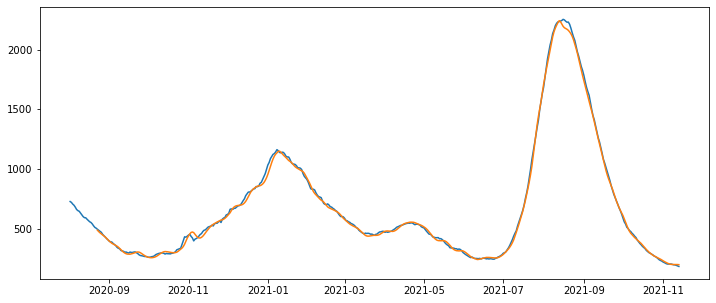

In [ ]:
predicting_length = model_predict.shape[0]

pyplot.figure(figsize=(12,5))
pyplot.plot(state_df['date'], state_df['smoothed_hosp'])
pyplot.plot(state_df['date'][-predicting_length:], model_predict)

#### Local Model 4: Smoothed hospitalization + Smoothed cases + SPC +SPH

In [ ]:
n_days = 21
n_features = 4

prediction_dict = {}

state='Georgia'
#for state in states:
print('-----', state, '-----')

state_df = df[df['location_name']=='Georgia']
values = state_df[['smoothed_hosp', 'smoothed_cases', 'spc', 'sph']].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, n_days, 1)
# drop columns we don't want to predict
# print(reframed.head())

score_dict = {'train_rmse':[],
              'test_rmse': []}

for i in range(0,11):
    # split into train and test sets
    values = reframed.values
    n_train_days = int(len(values) * 0.8)
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]
    # split into input and outputs
    n_obs = n_days * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    # print(train_X.shape, len(train_X), train_y.shape)
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
    # print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

    # Early stop
    # early_stopping = EarlyStopping(
    #     monitor='val_loss',
    #     patience=8,
    #     min_delta=0.001,
    #     mode='max'
    # )

    # design network
    model = Sequential()
    model.add(LSTM(64, activation='tanh',
                   return_sequences=True,
                   input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(64, activation='tanh'))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')


    # fit network
    history = model.fit(train_X, train_y, epochs=200, 
                        batch_size=72, 
                        validation_data=(test_X, test_y), 
                        verbose=2, shuffle=False)
    # plot history
    #     pyplot.plot(history.history['loss'], label='train')
    #     pyplot.plot(history.history['val_loss'], label='test')
    #     pyplot.legend()
    #     pyplot.show()

    model_predict_train = model.predict(train_X)
    train_X = train_X.reshape((train_X.shape[0], n_days*n_features))
    # invert scaling for forecast
    inv_yhat_train = concatenate((model_predict_train, train_X[:, -(n_features-1):]), axis=1)
    inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
    inv_yhat_train = inv_yhat_train[:,0]
    # invert scaling for actual
    train_y = train_y.reshape((len(train_y), 1))
    inv_y_train = concatenate((train_y, train_X[:, -(n_features-1):]), axis=1)
    inv_y_train = scaler.inverse_transform(inv_y_train)
    inv_y_train = inv_y_train[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y_train, inv_yhat_train))
    print('Train RMSE: %.3f' % rmse)
    score_dict['train_rmse'].append(rmse)

    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    score_dict['test_rmse'].append(rmse)

    model_predict = concatenate([inv_yhat_train, inv_yhat])
    prediction_dict[state] = model_predict
    
print(DataFrame(score_dict))

----- Georgia -----
Epoch 1/200
5/5 - 5s - loss: 0.0800 - val_loss: 0.2302 - 5s/epoch - 928ms/step
Epoch 2/200
5/5 - 0s - loss: 0.1365 - val_loss: 0.1970 - 99ms/epoch - 20ms/step
Epoch 3/200
5/5 - 0s - loss: 0.1000 - val_loss: 0.1892 - 94ms/epoch - 19ms/step
Epoch 4/200
5/5 - 0s - loss: 0.0750 - val_loss: 0.1521 - 103ms/epoch - 21ms/step
Epoch 5/200
5/5 - 0s - loss: 0.0756 - val_loss: 0.1371 - 90ms/epoch - 18ms/step
Epoch 6/200
5/5 - 0s - loss: 0.0615 - val_loss: 0.1156 - 96ms/epoch - 19ms/step
Epoch 7/200
5/5 - 0s - loss: 0.0513 - val_loss: 0.0967 - 95ms/epoch - 19ms/step
Epoch 8/200
5/5 - 0s - loss: 0.0521 - val_loss: 0.0692 - 97ms/epoch - 19ms/step
Epoch 9/200
5/5 - 0s - loss: 0.0439 - val_loss: 0.0825 - 95ms/epoch - 19ms/step
Epoch 10/200
5/5 - 0s - loss: 0.0423 - val_loss: 0.0777 - 96ms/epoch - 19ms/step
Epoch 11/200
5/5 - 0s - loss: 0.0416 - val_loss: 0.0953 - 98ms/epoch - 20ms/step
Epoch 12/200
5/5 - 0s - loss: 0.0379 - val_loss: 0.0770 - 95ms/epoch - 19ms/step
Epoch 13/200
5/5 

In [ ]:
DataFrame(score_dict['test_rmse']).median()

0    31.737594
dtype: float64

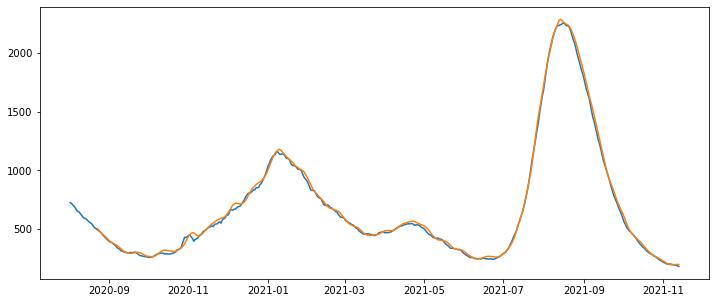

In [ ]:
predicting_length = model_predict.shape[0]

pyplot.figure(figsize=(12,5))
pyplot.plot(state_df['date'], state_df['smoothed_hosp'])
pyplot.plot(state_df['date'][-predicting_length:], model_predict)

#### Global Model: Using all the training data

In [ ]:
n_days = 21
n_features = 4

prediction_dict = {}

reframed = DataFrame()
i = 0
for state in states:
  state_df = df[df['location_name']==state]
  values = state_df[['smoothed_hosp', 'smoothed_cases', 'spc', 'sph']].values
  # ensure all data is float
  values = values.astype('float32')
  # normalize features
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled = scaler.fit_transform(values)
  # frame as supervised learning
  if i == 1:
    reframed_temp = series_to_supervised(scaled, n_days, 1)
    reframed = reframed_temp.copy()
  # drop columns we don't want to predict
  # print(reframed.head())
  else:
    reframed_temp = series_to_supervised(scaled, n_days, 1)
    reframed = reframed.append(reframed_temp)
reframed = reframed.reset_index(drop=True)

score_dict = {'train_rmse':[],
              'test_rmse': [],
              'test_pred': [],
              'ground_truth': []}

for i in range(1,2):
    print(f'-------------------- Round {i} --------------------')
    # split into train and test sets
    # Note: Need to be temporally continuous
    values = reframed.values

    n_train_days = int(len(reframed_temp) * 0.8)
    train_idx = []
    for i in range(len(states)):
      train_idx += list(range(0 + i*len(reframed_temp), n_train_days + i*len(reframed_temp)))

    train = np.take(values, train_idx, 0)
    test_idx = set(list(range(0, len(values)))) - set(train_idx)
    test = np.take(values, sorted(test_idx), 0)

    ##### Note: Only test Florida
    test = test[-90*4:]

    # split into input and outputs
    n_obs = n_days * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    # print(train_X.shape, len(train_X), train_y.shape)
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
    # print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

    # Early stop
    # early_stopping = EarlyStopping(
    #     monitor='val_loss',
    #     patience=8,
    #     min_delta=0.001,
    #     mode='max'
    # )

    # design network
    model = Sequential()
    model.add(LSTM(64, activation='tanh',
                   return_sequences=True,
                   input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(64, activation='tanh'))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')


    # fit network
    history = model.fit(train_X, train_y, epochs=200, 
                        batch_size=72, 
                        validation_data=(test_X, test_y), 
                        verbose=2, shuffle=False)
    # plot history
    #     pyplot.plot(history.history['loss'], label='train')
    #     pyplot.plot(history.history['val_loss'], label='test')
    #     pyplot.legend()
    #     pyplot.show()

    model_predict_train = model.predict(train_X)
    train_X = train_X.reshape((train_X.shape[0], n_days*n_features))
    # invert scaling for forecast
    inv_yhat_train = concatenate((model_predict_train, train_X[:, -(n_features-1):]), axis=1)
    inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
    inv_yhat_train = inv_yhat_train[:,0]
    # invert scaling for actual
    train_y = train_y.reshape((len(train_y), 1))
    inv_y_train = concatenate((train_y, train_X[:, -(n_features-1):]), axis=1)
    inv_y_train = scaler.inverse_transform(inv_y_train)
    inv_y_train = inv_y_train[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y_train, inv_yhat_train))
    print('Train RMSE: %.3f' % rmse)
    score_dict['train_rmse'].append(rmse)

    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    score_dict['test_rmse'].append(rmse)
    score_dict['test_pred'].append(inv_yhat)
    score_dict['ground_truth'].append(inv_y)

    model_predict = concatenate([inv_yhat_train, inv_yhat])
    prediction_dict[state] = model_predict
    
print(DataFrame(score_dict))

-------------------- Round 1 --------------------
Epoch 1/200
244/244 - 11s - loss: 0.0590 - val_loss: 0.0331 - 11s/epoch - 44ms/step
Epoch 2/200
244/244 - 3s - loss: 0.0333 - val_loss: 0.0288 - 3s/epoch - 12ms/step
Epoch 3/200
244/244 - 3s - loss: 0.0258 - val_loss: 0.0161 - 3s/epoch - 12ms/step
Epoch 4/200
244/244 - 3s - loss: 0.0221 - val_loss: 0.0191 - 3s/epoch - 12ms/step
Epoch 5/200
244/244 - 3s - loss: 0.0195 - val_loss: 0.0152 - 3s/epoch - 12ms/step
Epoch 6/200
244/244 - 3s - loss: 0.0178 - val_loss: 0.0137 - 3s/epoch - 12ms/step
Epoch 7/200
244/244 - 3s - loss: 0.0162 - val_loss: 0.0114 - 3s/epoch - 12ms/step
Epoch 8/200
244/244 - 3s - loss: 0.0154 - val_loss: 0.0139 - 3s/epoch - 12ms/step
Epoch 9/200
244/244 - 3s - loss: 0.0129 - val_loss: 0.0123 - 3s/epoch - 12ms/step
Epoch 10/200
244/244 - 3s - loss: 0.0135 - val_loss: 0.0094 - 3s/epoch - 12ms/step
Epoch 11/200
244/244 - 3s - loss: 0.0129 - val_loss: 0.0099 - 3s/epoch - 12ms/step
Epoch 12/200
244/244 - 3s - loss: 0.0115 - v

In [ ]:
score_dict_df = DataFrame(score_dict)
score_dict_df

,train_rmse,test_rmse,test_pred,ground_truth
0,24.084844,14.531372,"[1837.8994, 1853.7299, 1886.0381, 1925.4955, 1...","[1829.2168, 1853.5896, 1906.7301, 1893.9445, 1..."


#### Separate predictions for test dataset and Calculate RMSE for 4 states

In [ ]:
score_dict = {'test_rmse': [],
                 'test_pred': [],
                 'ground_truth': []}

for state in states[-4:]:
    prediction_dict = {}
    print('----------', state, '----------')

    state_df = df[df['location_name']==state]
    values = state_df[['smoothed_hosp', 'smoothed_cases', 'spc', 'sph']].values
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, n_days, 1)
    # drop columns we don't want to predict
    # print(reframed.head())

    # score_dict = {'test_rmse': [],
    #               'test_pred': [],
    #               'ground_truth': []}
    
    # split into train and test sets
    values = reframed.values
    n_train_days = int(len(values) * 0.8)
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]
    # split into input and outputs
    n_obs = n_days * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    # print(train_X.shape, len(train_X), train_y.shape)
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_days, n_features))

    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    score_dict['test_rmse'].append(rmse)
    score_dict['test_pred'].append(inv_yhat)
    score_dict['ground_truth'].append(inv_y)
    


---------- Georgia ----------
Test RMSE: 5.595
---------- California ----------
Test RMSE: 5.810
---------- Alabama ----------
Test RMSE: 4.483
---------- Florida ----------
Test RMSE: 9.559


In [ ]:
from google.colab import files

In [ ]:
state_rmse_df_gl = DataFrame(score_dict)
state_rmse_df_gl['state'] = states[-4:]

state_rmse_df_gl.to_csv('model_gl.csv', index=False)
files.download('model_gl.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_pred_df = DataFrame({'ground_truth': list(state_rmse_df_gl['ground_truth']),
                         'model_gl': list(state_rmse_df_gl['test_pred'])})

i=0
for state in states[-4:]:
    pred_stat = DataFrame([list(test_pred_df['ground_truth'][i]), 
                           list(test_pred_df['model_gl'][i])])
    pred_stat.to_csv(f'{state}_pred_gl.csv', index=False)
    files.download(f'{state}_pred_gl.csv')
    i+=1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>